In [1]:
from pypfopt import risk_models,expected_returns,EfficientFrontier
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from src.config import load_config
import numpy as np
from pypfopt.discrete_allocation import DiscreteAllocation,get_latest_prices

class EfficientDiversification:
    def __init__(self,config):
        self.config = config
        self.all_prices = None #all assets combined
        self.mu = None # expected returns using pyportfolio
        self.S = None # Risk(Vol) through pyportfolio
        self.ef = None # Efficient Frontier using pyportfolio
        self.weights = None # weights
        self.performance = None # portfolio performance
        
    def load_data(self):
        """Loads in data from yfinance using config.yaml"""
        self.all_prices = yf.download(tickers=self.config['combined_assets'],start=self.config['start_date'],end=self.config['end_date'])['Close']
        self.all_prices = self.all_prices.dropna()
        return self.all_prices   
    
    def eval_returns(self):
        """
        The pct change for each asset(returns). This is not the same
        as 'Expected Returns'
        """

        returns = self.all_prices.pct_change().dropna()
        print(f'Returns: {returns}')
        return returns
    
    
    def portfolio_metrics(self):
        """
        args:
            (mu) -> Expected Returns (using pyportfolio)
            (S) -> Risk(Volatility);
            (Ef) -> Efficient Frontier;
        """

        if self.all_prices is None:
            self.load_data()
            if self.all_prices is None:
                return
            
        self.mu = expected_returns.mean_historical_return(self.all_prices)
        self.S = risk_models.sample_cov(self.all_prices)
        self.ef = EfficientFrontier(self.mu,self.S)

        
    def optimizing_portfolio(self):
        """Optimizing Returns based on Efficient Frontier and Weights(there are four)"""
        if self.mu is None or self.S is None:
            self.portfolio_metrics()
            
        self.ef = EfficientFrontier(self.mu,self.S)
        self.weights = self.ef.max_sharpe()
        self.weights = self.ef.clean_weights()


            
        expected_annual_return, annual_volatility, sharpe_ratio = self.ef.portfolio_performance(verbose=True)
        self.performance = {
            "Expected Annual Return":expected_annual_return,
            "Annual Volatility":annual_volatility,
            "Sharpe Ratio":sharpe_ratio
        }
        return self.weights,self.performance



if __name__ == "__main__":
    config = load_config()
    ef_obj = EfficientDiversification(config)


In [2]:
data = ef_obj.load_data()
data

/tmp/ipykernel_90626/247997650.py:22: FutureWarning: YF.download() has changed argument auto_adjust default to True
  self.all_prices = yf.download(tickers=self.config['combined_assets'],start=self.config['start_date'],end=self.config['end_date'])['Close']
[*********************100%***********************]  34 of 34 completed


Ticker,AADR,AAPL,ARKW,BLCN,BLOK,BNB-USD,BTC-USD,ETH-USD,F,FPX,...,TRX-USD,TSLA,URA,USDC-USD,USDT-USD,VZ,WBA,WMT,XRP-USD,XSD
Date,,,,,,,,,,,,,,,,,,,,,
2021-04-22,60.262943,128.753922,144.490158,46.456375,40.609192,506.013000,51762.273438,2403.535156,9.164265,121.282440,...,0.110130,239.896667,16.138144,1.000028,1.000090,44.113029,42.141171,43.768730,1.159682,178.968399
2021-04-23,61.287666,131.076416,147.895645,46.990917,41.044174,526.565247,51093.652344,2363.586182,9.379174,124.274887,...,0.109025,243.133331,16.378883,0.999978,1.000162,44.128437,42.493820,43.840801,1.169660,184.775055
2021-04-26,61.930443,131.466797,152.507660,47.292202,42.956451,534.577698,54021.753906,2534.481689,9.417551,125.633293,...,0.117295,246.066666,16.507853,0.999987,1.000042,43.851192,42.261398,43.217194,1.368506,188.488113
2021-04-27,61.986328,131.144730,150.921661,47.331074,43.128799,568.470520,55033.117188,2662.865234,9.586405,125.032829,...,0.125794,234.913330,16.636820,0.999927,1.000062,43.373707,42.085064,43.364479,1.400955,186.957474
2021-04-28,62.172653,130.354324,150.026520,47.389393,43.489922,562.632568,54824.703125,2746.380127,9.540354,124.737526,...,0.122684,231.466660,17.032316,1.000199,1.000052,43.458420,41.996914,43.210930,1.358601,184.083771
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-21,82.080002,224.899994,152.600006,23.290001,57.459999,839.040833,112419.031250,4223.209961,11.330000,146.789993,...,0.353541,320.109985,37.180000,0.999710,0.999645,45.029999,12.190000,97.959999,2.850474,274.480011
2025-08-22,84.180000,227.759995,158.309998,23.834999,59.520000,898.774536,116874.085938,4831.348633,11.740000,149.470001,...,0.366415,340.010010,39.439999,0.999823,0.999714,44.439999,12.070000,96.830002,3.075773,286.029999
2025-08-25,83.410004,227.160004,156.449997,23.799999,58.919998,840.171936,110124.351562,4372.987793,11.820000,149.160004,...,0.342051,346.600006,39.490002,0.999871,1.000123,44.230000,11.970000,96.070000,2.861272,283.309998


In [3]:
returns = ef_obj.eval_returns()
returns

Returns: Ticker          AADR      AAPL      ARKW      BLCN      BLOK   BNB-USD  \
Date                                                                     
2021-04-23  0.017004  0.018038  0.023569  0.011506  0.010711  0.040616   
2021-04-26  0.010488  0.002978  0.031184  0.006412  0.046591  0.015216   
2021-04-27  0.000902 -0.002450 -0.010399  0.000822  0.004012  0.063401   
2021-04-28  0.003006 -0.006027 -0.005931  0.001232  0.008373 -0.010270   
2021-04-29 -0.004945 -0.000749 -0.026526 -0.002256 -0.030194  0.065894   
...              ...       ...       ...       ...       ...       ...   
2025-08-21  0.004528 -0.004911 -0.006640 -0.006187 -0.003641 -0.034591   
2025-08-22  0.025585  0.012717  0.037418  0.023401  0.035851  0.071193   
2025-08-25 -0.009147 -0.002634 -0.011749 -0.001468 -0.010081 -0.065203   
2025-08-26 -0.002997  0.009465  0.006711 -0.008613  0.015445  0.027921   
2025-08-27 -0.015272  0.005146 -0.001651  0.006357 -0.003176 -0.009245   

Ticker       BTC-USD   ETH-U

Ticker,AADR,AAPL,ARKW,BLCN,BLOK,BNB-USD,BTC-USD,ETH-USD,F,FPX,...,TRX-USD,TSLA,URA,USDC-USD,USDT-USD,VZ,WBA,WMT,XRP-USD,XSD
Date,,,,,,,,,,,,,,,,,,,,,
2021-04-23,0.017004,0.018038,0.023569,0.011506,0.010711,0.040616,-0.012917,-0.016621,0.023451,0.024673,...,-0.010034,0.013492,0.014917,-0.000050,0.000072,0.000349,0.008368,0.001647,0.008604,0.032445
2021-04-26,0.010488,0.002978,0.031184,0.006412,0.046591,0.015216,0.057309,0.072303,0.004092,0.010931,...,0.075854,0.012065,0.007874,0.000009,-0.000120,-0.006283,-0.005470,-0.014224,0.170003,0.020095
2021-04-27,0.000902,-0.002450,-0.010399,0.000822,0.004012,0.063401,0.018721,0.050655,0.017930,-0.004779,...,0.072458,-0.045326,0.007812,-0.000060,0.000020,-0.010889,-0.004172,0.003408,0.023711,-0.008121
2021-04-28,0.003006,-0.006027,-0.005931,0.001232,0.008373,-0.010270,-0.003787,0.031363,-0.004804,-0.002362,...,-0.024723,-0.014672,0.023772,0.000272,-0.000010,0.001953,-0.002095,-0.003541,-0.030232,-0.015371
2021-04-29,-0.004945,-0.000749,-0.026526,-0.002256,-0.030194,0.065894,-0.023157,0.003822,-0.094127,-0.008128,...,-0.011566,-0.025058,-0.003533,-0.000055,-0.000086,0.015772,0.006489,0.012619,0.030001,-0.011051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-21,0.004528,-0.004911,-0.006640,-0.006187,-0.003641,-0.034591,-0.016239,-0.025676,-0.013925,0.000000,...,-0.002280,-0.011701,0.020027,-0.000109,-0.000410,-0.000666,-0.000820,-0.044945,-0.033983,0.002154
2025-08-22,0.025585,0.012717,0.037418,0.023401,0.035851,0.071193,0.039629,0.143999,0.036187,0.018257,...,0.036414,0.062166,0.060785,0.000113,0.000069,-0.013102,-0.009844,-0.011535,0.079039,0.042080
2025-08-25,-0.009147,-0.002634,-0.011749,-0.001468,-0.010081,-0.065203,-0.057752,-0.094872,0.006814,-0.002074,...,-0.066493,0.019382,0.001268,0.000048,0.000409,-0.004725,-0.008285,-0.007849,-0.069739,-0.009509


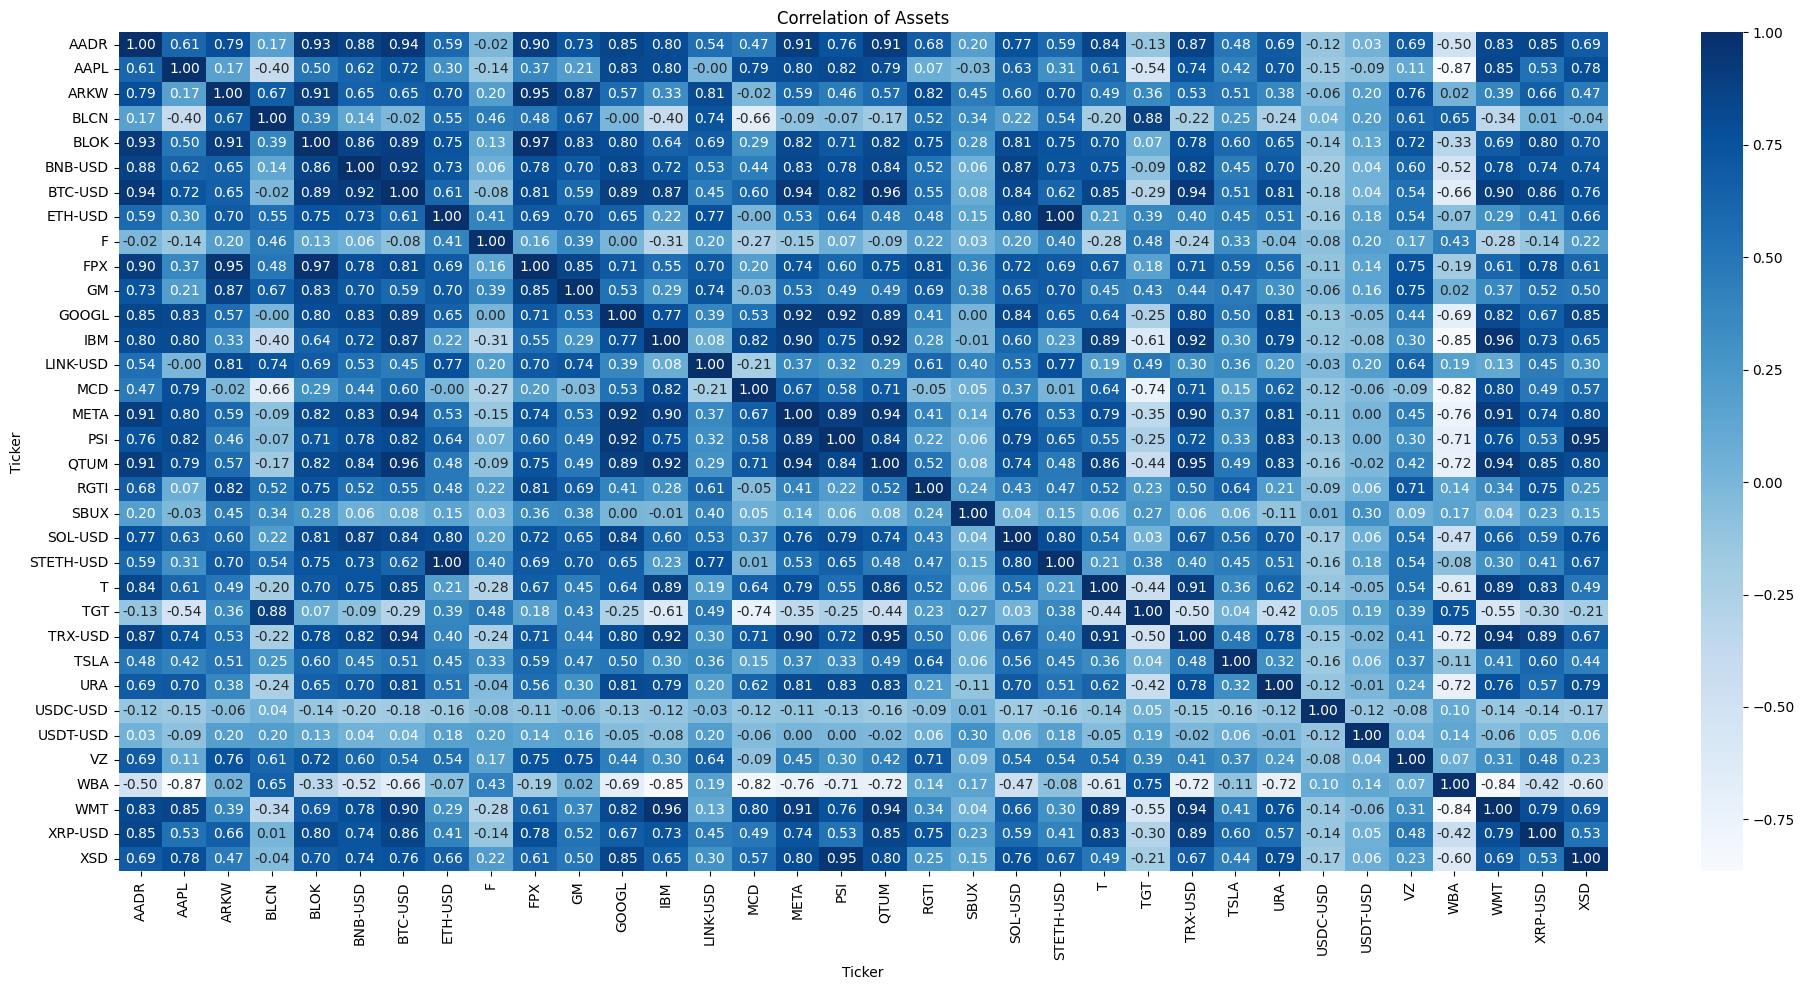

In [4]:
plt.figure(figsize=(20,10))
sns.heatmap(data.corr(),fmt=".2f",annot=True,cmap="Blues")
plt.title("Correlation of Assets")
plt.tight_layout()
plt.savefig("images/ef_assets_heatmap.png")
plt.show()

Value at Risk: -0.0446
Conditonal Value at Risk(CVaR): -0.0761%


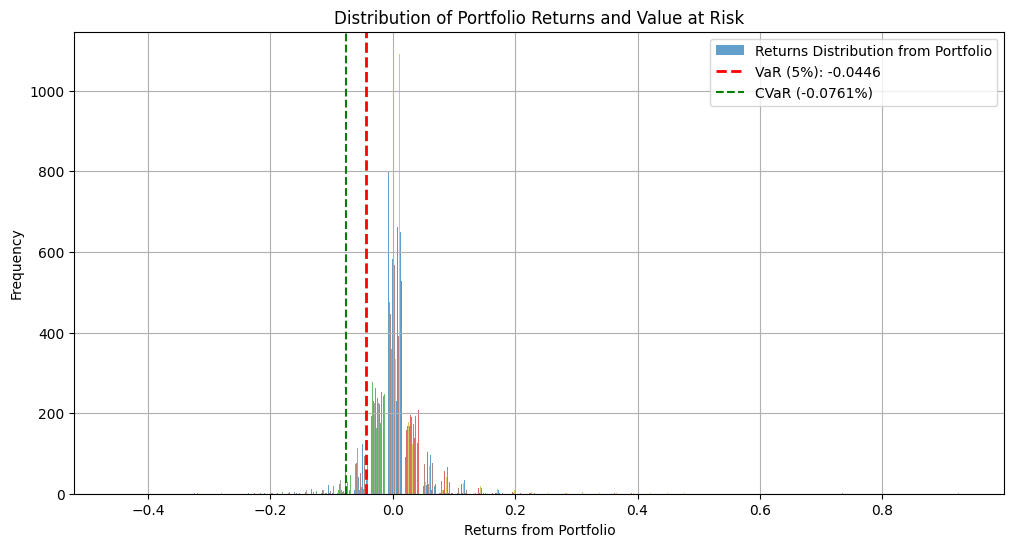

In [5]:
var = np.percentile(returns,(1- 0.95)*100)
tail_risk = returns[returns < var]
cvar = np.mean(tail_risk)
print(f"Value at Risk: {var:.4f}")
print(f'Conditonal Value at Risk(CVaR): {cvar:.4f}%')

plt.figure(figsize=(12,6))
plt.hist(returns,bins=50,label="Returns Distribution from Portfolio",alpha=0.7)
plt.axvline(var, color='r', linestyle='dashed', linewidth=2, label=f'VaR (5%): {var:.4f}')
plt.axvline(x=cvar, color='green', linestyle='--', label=f'CVaR ({cvar:.4f}%)')
plt.title('Distribution of Portfolio Returns and Value at Risk')
plt.xlabel('Returns from Portfolio')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.savefig("images/VaR-Cvar-EfficientDiversification.png")
plt.show()


In [6]:
optimal_portfolio = ef_obj.optimizing_portfolio()
optimal_portfolio

Expected annual return: 13.7%
Annual volatility: 11.0%
Sharpe Ratio: 1.24


(OrderedDict([('AADR', 0.0),
              ('AAPL', 0.0),
              ('ARKW', 0.0),
              ('BLCN', 0.0),
              ('BLOK', 0.0),
              ('BNB-USD', 0.0),
              ('BTC-USD', 0.0),
              ('ETH-USD', 0.0),
              ('F', 0.0),
              ('FPX', 0.0),
              ('GM', 0.0),
              ('GOOGL', 0.0),
              ('IBM', 0.2005),
              ('LINK-USD', 0.0),
              ('MCD', 0.03229),
              ('META', 0.02735),
              ('PSI', 0.0),
              ('QTUM', 0.02822),
              ('RGTI', 0.0),
              ('SBUX', 0.0),
              ('SOL-USD', 0.01119),
              ('STETH-USD', 0.0),
              ('T', 0.05319),
              ('TGT', 0.0),
              ('TRX-USD', 0.01789),
              ('TSLA', 0.0),
              ('URA', 0.02987),
              ('USDC-USD', 0.30612),
              ('USDT-USD', 0.0),
              ('VZ', 0.0),
              ('WBA', 0.0),
              ('WMT', 0.29337),
              ('XR

In [7]:
# all of the weights have to add up to 1

#checking to see if math holds(it does, but you know, here)


W_star =  0.2005 + 0.03229 +  0.02735 + 0.02822 + 0.01119 + 0.05319 + 0.01789 + 0.02987 + 0.30612 + 0.29337


print(f'Sum of all of the weights combined: {W_star}')



Sum of all of the weights combined: 0.99999


In [8]:
weights = ef_obj.weights

In [9]:
#greedy investor and discrete allocation

latest_prices = get_latest_prices(data)
# Discrete Allocation is using the optimized weights and your Willingness to Pay to show you how much you would recieve st W* and WTP
da = DiscreteAllocation(weights, latest_prices,total_portfolio_value=1000000)
print(f'Latest Prices: {latest_prices}')
allocation, leftover = da.greedy_portfolio()
print(f'Allocation to Assets if you have $1000000 USD: {allocation}')
print(f'Leftover Cash if you were to spend $1000000 USD on optimized Weights: {leftover}')

Latest Prices: Ticker
AADR             81.889999
AAPL            230.490005
ARKW            157.240005
BLCN             23.745001
BLOK             59.639999
BNB-USD         855.646301
BTC-USD      111222.062500
ETH-USD        4503.393066
F                11.910000
FPX             150.610001
GM               58.750000
GOOGL           207.479996
IBM             244.839996
LINK-USD         23.757828
MCD             311.429993
META            747.380005
PSI              63.779999
QTUM             94.989998
RGTI             15.390000
SBUX             87.660004
SOL-USD         202.923370
STETH-USD      4499.626465
T                29.059999
TGT              97.959999
TRX-USD           0.345050
TSLA            349.600006
URA              39.680000
USDC-USD          0.999989
USDT-USD          1.000059
VZ               44.270000
WBA              11.980000
WMT              96.080002
XRP-USD           2.966618
XSD             288.739990
Name: 2025-08-27 00:00:00, dtype: float64
Allocation to Asse

In [10]:
mu = ef_obj.mu
volatility = ef_obj.S
sharpe_ratio = mu - 0.0092 / volatility
print(f'Expected Returns of Full Portfolio: {mu}')
print(f'volatility of full portfolio: {volatility}')
print(f'sharpe ratio of full portfolio: {sharpe_ratio}')

Expected Returns of Full Portfolio: Ticker
AADR         0.073332
AAPL         0.143825
ARKW         0.019706
BLCN        -0.143481
BLOK         0.092744
BNB-USD      0.128875
BTC-USD      0.193044
ETH-USD      0.155921
F            0.062343
FPX          0.051248
GM           0.015686
GOOGL        0.153005
IBM          0.198059
LINK-USD    -0.086929
MCD          0.093343
META         0.239365
PSI          0.114049
QTUM         0.182707
RGTI         0.107175
SBUX        -0.040307
SOL-USD      0.464205
STETH-USD    0.157158
T            0.118218
TGT         -0.133010
TRX-USD      0.301536
TSLA         0.090791
URA          0.230738
USDC-USD    -0.000009
USDT-USD    -0.000007
VZ           0.000820
WBA         -0.251930
WMT          0.198949
XRP-USD      0.242041
XSD          0.116703
dtype: float64
volatility of full portfolio: Ticker         AADR      AAPL      ARKW      BLCN      BLOK   BNB-USD  \
Ticker                                                                  
AADR       0.04631

/tmp/ipykernel_90626/2285642073.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


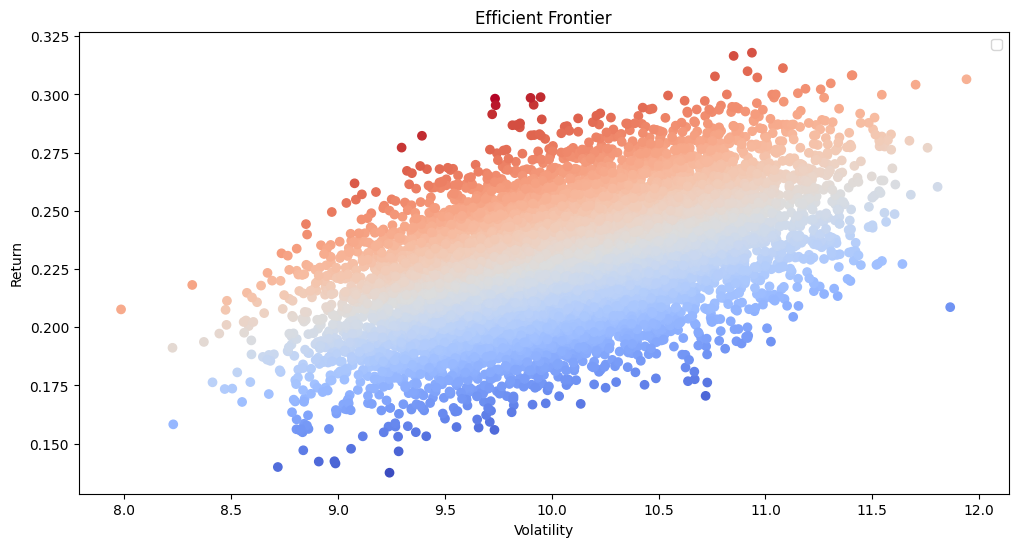

In [11]:

mean_returns = returns.mean()
num_portfolios = 10000
corr_matrix = data.corr()
results = np.zeros((3,num_portfolios))
for i in range(num_portfolios):
    weights = np.random.random(len(mean_returns))
    weights /= np.sum(weights)
  
    portfolio_return = np.sum(mean_returns * weights) * 252
    portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(corr_matrix, weights))) * np.sqrt(252)
      
    results[0,i] = portfolio_return
    results[1,i] = portfolio_std_dev
    results[2,i] = portfolio_return / portfolio_std_dev
  
results_df = pd.DataFrame(results.T,columns=['Return','Volatility','Sharpe'])

plt.figure(figsize=(12,6))
plt.scatter(results_df['Volatility'], results_df['Return'], c=results_df['Sharpe'], cmap='coolwarm')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.title('Efficient Frontier')
plt.legend()
plt.savefig("images/discount_ef.png")
plt.show()